In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
import collections

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import xgboost as xgb

from FairReg import FairReg
from unfairness_measures import DP_unfairness, probabilistic_pred_unfairness
from plots import plot_distributions_compare, plot_predictions_compare, plot_distributions, plot_predictions

### Data preprocessing

Racial encoding for Lawschool Dataset: 1.0 : American Indian; 2.0 : Asian; 3.0 : Black; 4.0 : Mexican American; 5.0 : Puerto Rican; 6.0 : Other Hispanic; 7.0 : White; 8.0 : Others.

In [18]:
df = pd.read_csv('./data/lawschool.csv')
df = df.dropna()
y = df['ugpa'] #target: gpa \in [0,4]
df = df.drop('ugpa', axis=1)
df['gender'] = df['gender'].map({'male': 1, 'female': 0})
df_bar = df['bar1']
df = df.drop('bar1', axis=1)
df['bar1'] = [int(grade == 'P') for grade in df_bar]
df['race'] = [int(race == 7.0) for race in df['race']] #setting S=1 for white race, S=0 for non-white race
S = df['race'] #sensitive attribute
df = df.drop('race', axis=1)
X = df.to_numpy() #features

In [19]:
#getting the frequencies of the sensitive values

p_0 = S.value_counts(1)[0] #non-white
p_1 = S.value_counts(1)[1] #white

Splitting data into **train**, **unlab** and **test** groups

In [20]:
TRAIN_SIZE, UNLAB_SIZE, TEST_SIZE = 0.4, 0.4, 0.2

X_train, X_, S_train, S_, y_train, y_ = train_test_split(X, S, y, train_size = TRAIN_SIZE, stratify = S)
X_unlab, X_test, S_unlab, S_test, y_unlab, y_test = train_test_split(X_, S_, y_, test_size = TEST_SIZE/(1-TRAIN_SIZE), stratify = S_)

Training the **base (unfair) regression** method to predict **y** given **X**

In [21]:
param_reg = {'max_depth': 10, 'objective':
                 'reg:linear', 'n_estimators': 400, 'reg_lambda' : 1, 'gamma':2}
reg = xgb.XGBRegressor(**param_reg)
reg.fit(X_train,y_train)

[03:19:05] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

Training a **classifier** to predict **S** given **X**

In [22]:
param_clf = {'max_depth': 5, 'objective': 'binary:logistic', 'n_estimators': 200, 'gamma':2}
clf = xgb.XGBClassifier(**param_clf)
clf.fit(X_train,S_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Training the **fair regression** to predict **y** given **X**

In [23]:
fair_reg = FairReg(reg, clf, B=4, K=2,  p=[p_0, p_1], eps=[0.0001, 0.0001], T=10000)
fair_reg.fit(X_unlab)

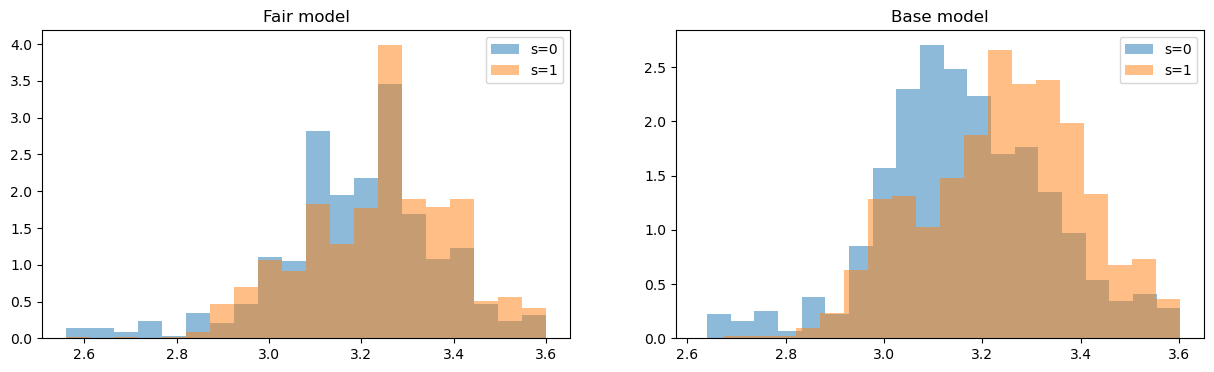

In [24]:
plot_distributions_compare(fair_reg, reg, X_test, S_test)

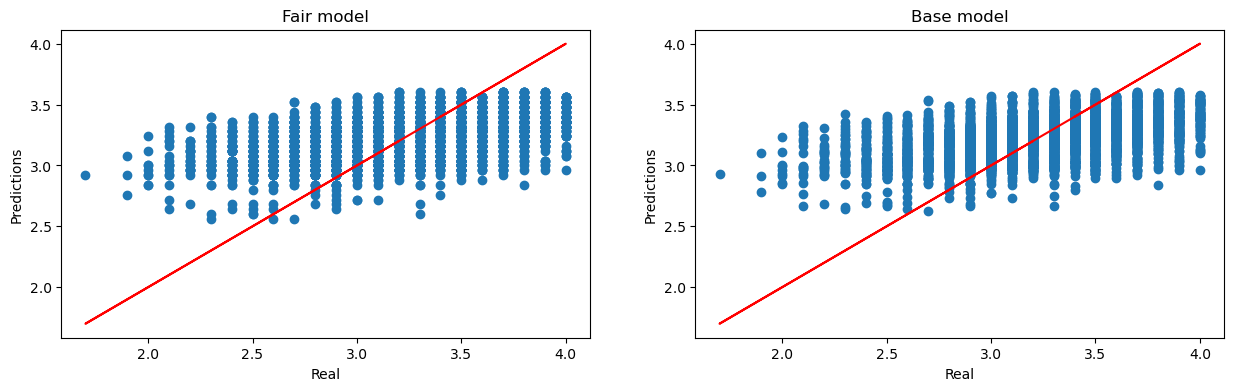

In [25]:
plot_predictions_compare(fair_reg, reg, X_test, y_test)

### Unfairness in the grid

In [26]:
unf = probabilistic_pred_unfairness(fair_reg, X_test, S_test)
print("For our notion of fairness (in the grid)")
print("============================================================")
for key, value in unf.items():
    print("sum unfairness for s="+str(key)+" is "+str(sum(value)))
    print("max unfairness for s="+str(key)+" is "+str(max(value)))
    print("average unfairness for s="+str(key)+" is "+str(value.mean()))
    print("============================================================")

For our notion of fairness (in the grid)
sum unfairness for s=0 is 0.11961661043579834
max unfairness for s=0 is 0.0049167696675333425
average unfairness for s=0 is 0.0005951075146059619
sum unfairness for s=1 is 0.02259045128516113
max unfairness for s=1 is 0.000928567071497001
average unfairness for s=1 is 0.00011239030490129917


### DP-unfairness

In [27]:
bins = fair_reg.Q_L

##### For fair predictor

In [28]:
y_test_pred_fair = fair_reg.predict(X_test)
DP_unfairness(y_test_pred_fair, S_test, bins=bins)

{0: 0.12577347249748316, 1: 0.0237532186630961}

In [29]:
print("The MSE risk of the fair predictor is "+str(mse(y_test, y_test_pred_fair)))

The MSE risk of the fair predictor is 0.12668079788512376


##### For base predictor


In [30]:
y_test_pred_base = reg.predict(X_test)
DP_unfairness(y_test_pred_base, S_test, bins=bins)

{0: 0.2029783804006733, 1: 0.038333916984241434}

In [31]:
print("The MSE risk of the base predictor is "+str(mse(y_test, y_test_pred_base)))

The MSE risk of the base predictor is 0.12467773963984218


#### In the test data

In [32]:
DP_unfairness(y_test, S_test, bins=bins)

{0: 0.19671424847323382, 1: 0.03715089092594498}